In [51]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [52]:
# MNIST: mean std => normalization
mean_gray = 0.1307
stddev_gray = 0.3081

# Transformer    img => tensors
transforms_ori = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))])

transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])

In [53]:
#Load our dataset
train_dataset = datasets.MNIST(root = './data', 
                            train = True, 
                            transform = transforms_ori,
                            download = True)

test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms_ori)

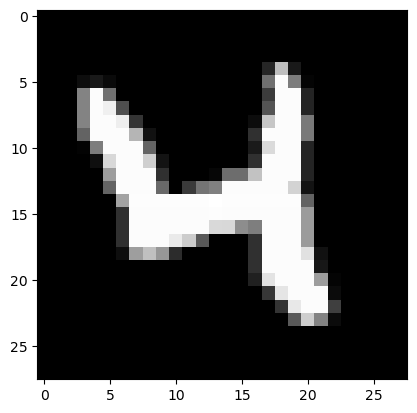

In [54]:
## img
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [55]:
## label
train_dataset[20][1]

4

In [56]:
batch_size = 100
epochs = 10
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)

In [57]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [58]:
#NN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # input size = output size => need to compute by kernel size
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is 
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=25088, out_features=700)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=700, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        #out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        #out = self.maxpool2(out)
        #Now we have to flatten the output.  
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,25088)
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [59]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [60]:

iteration = 0
correct_nodata = 0
correct_data = 0
for i,(inputs,labels) in enumerate (train_load):
    if iteration==1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print("For one iteration, this is what happens:")
    print("Input Shape:",inputs.shape)
    print("Labels Shape:",labels.shape)
    output = model(inputs)
    print("Outputs Shape",output.shape)
    _, predicted_nodata = torch.max(output, 1)
    print("Predicted Shape",predicted_nodata.shape)
    print("Predicted Tensor:")
    print(predicted_nodata)
    correct_nodata += (predicted_nodata == labels).sum()
    print("Correct Predictions: ",correct_nodata)
    _, predicted_data = torch.max(output.data, 1)
    correct_data += (predicted_data == labels.data).sum()
    print("Correct Predictions:",correct_data)
    

    iteration += 1

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([3, 6, 0, 0, 0, 3, 2, 5, 3, 7, 8, 4, 4, 4, 0, 4, 0, 0, 3, 6, 6, 0, 2, 7,
        4, 4, 4, 6, 2, 8, 6, 0, 0, 3, 8, 9, 4, 4, 0, 7, 4, 6, 0, 4, 0, 4, 0, 0,
        6, 0, 0, 3, 4, 8, 0, 8, 4, 8, 1, 4, 4, 8, 6, 0, 0, 4, 0, 4, 2, 3, 0, 8,
        6, 6, 6, 0, 7, 0, 1, 0, 6, 4, 6, 0, 8, 3, 4, 4, 0, 6, 0, 8, 7, 8, 0, 0,
        2, 0, 0, 6])
Correct Predictions:  tensor(12)
Correct Predictions: tensor(12)


In [61]:
#Training the CNN
num_epochs = 10

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()       # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        los = loss_fn(outputs, labels) # Calculate the loss
        loss += los.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 0.284, Training Accuracy: 91.947, Testing Loss: 0.104, Testing Acc: 97.040
Epoch 2/10, Training Loss: 0.102, Training Accuracy: 97.137, Testing Loss: 0.065, Testing Acc: 98.060
Epoch 3/10, Training Loss: 0.071, Training Accuracy: 97.922, Testing Loss: 0.053, Testing Acc: 98.360
Epoch 4/10, Training Loss: 0.056, Training Accuracy: 98.405, Testing Loss: 0.045, Testing Acc: 98.610
Epoch 5/10, Training Loss: 0.047, Training Accuracy: 98.622, Testing Loss: 0.041, Testing Acc: 98.640
Epoch 6/10, Training Loss: 0.039, Training Accuracy: 98.888, Testing Loss: 0.038, Testing Acc: 98.810
Epoch 7/10, Training Loss: 0.035, Training Accuracy: 99.018, Testing Loss: 0.035, Testing Acc: 98.830
Epoch 8/10, Training Loss: 0.030, Training Accuracy: 99.150, Testing Loss: 0.034, Testing Acc: 98.800
Epoch 9/10, Training Loss: 0.026, Training Accuracy: 99.278, Testing Loss: 0.033, Testing Acc: 98.880
Epoch 10/10, Training Loss: 0.024, Training Accuracy: 99.332, Testing Loss: 0.032,

In [62]:
#save the model
torch.save(model.state_dict(),'CNN_MNIST.pth')
#load the model 
# model.load_state_dict(torch.load('CNN_MNIST.pth'))

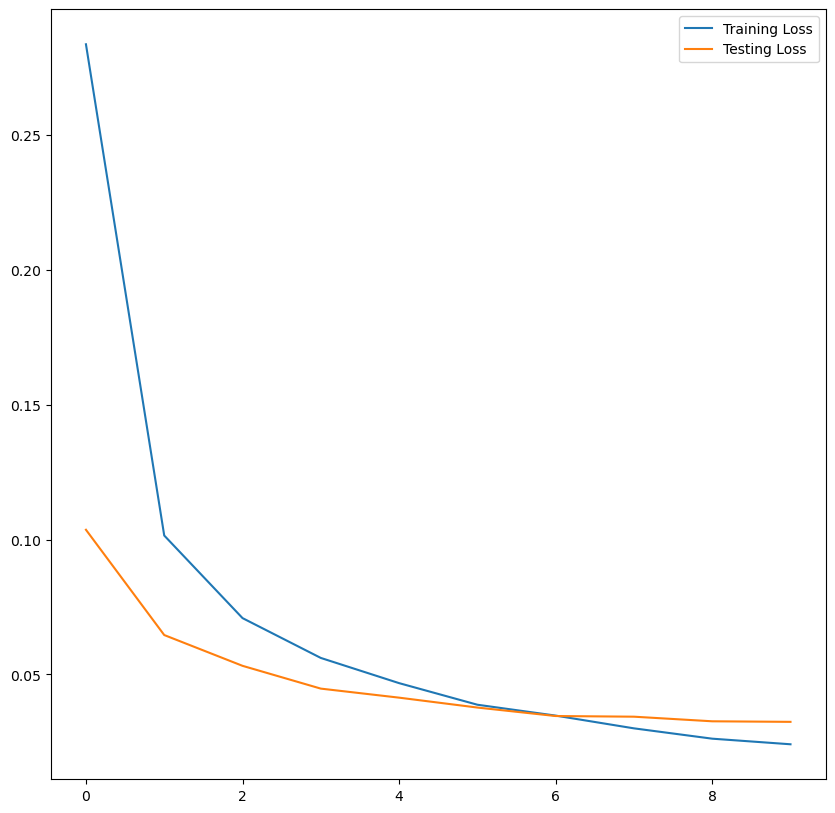

In [63]:
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

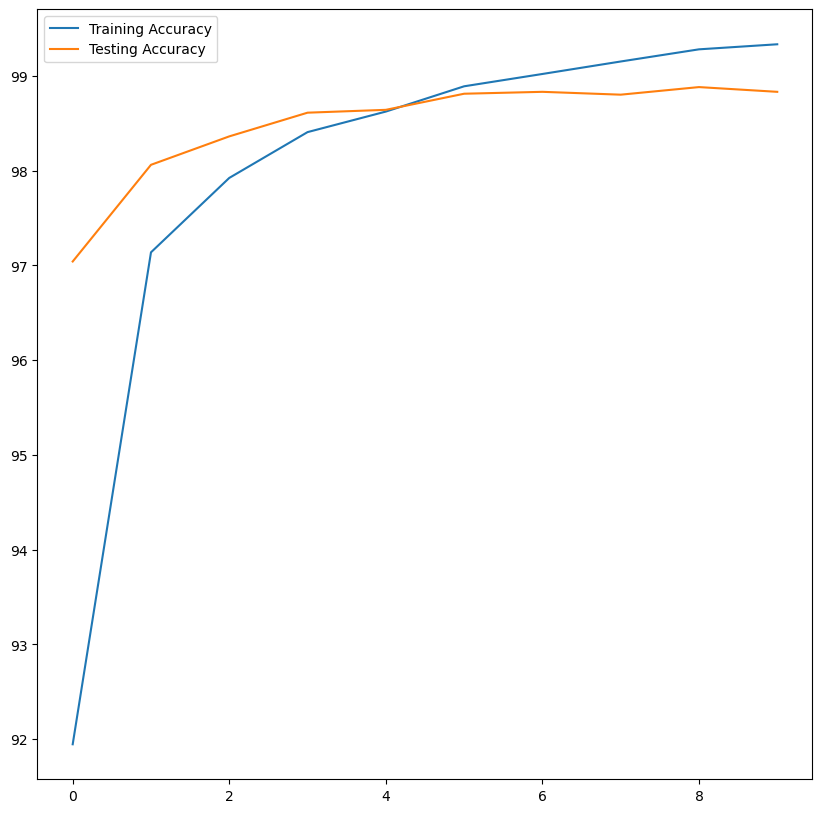

In [64]:
# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

## Test my img

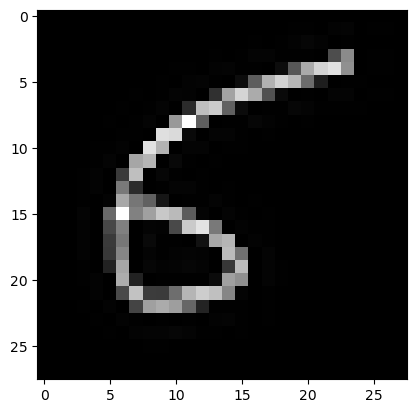

In [65]:
import cv2 
import matplotlib.pyplot as plt
import tensorflow as tf

# Load sample image
file = 'my_6.png'
test_image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

# Preview sample image
plt.imshow(test_image, cmap='gray')

# Format Image
img_resized = cv2.resize(test_image, (28, 28), interpolation=cv2.INTER_LINEAR)
img_resized = cv2.bitwise_not(img_resized)

# Preview reformatted image
plt.imshow(img_resized, cmap='gray')

#my_6 = tf.convert_to_tensor(img_resized)

In [66]:
img = transforms.ToTensor()(img_resized)
images = img.view(1,1,28,28)    
if CUDA:
    images = images.cuda()
    labels = labels.cuda()

outputs = model(images)       
_, predicted = torch.max(outputs.data, 1) 

In [67]:
print(predicted)

tensor([5])


In [68]:
outputs

tensor([[ 0.3360, -0.7970,  0.0463, -0.7583, -0.1790,  1.6223,  0.0951, -0.4822,
          1.0733,  0.3810]], grad_fn=<AddmmBackward0>)

In [69]:
from PIL import Image
test_image = Image.open("my_6.png") 
img = transforms_photo(test_image)
# img = Variable(img)

In [70]:
outputs = model(img.unsqueeze(0))       
_, predicted = torch.max(outputs.data, 1) 
predicted

tensor([8])

In [71]:
test_image = Image.open("my_6.png") 
img = transforms_photo(test_image)
img.size()

torch.Size([1, 28, 28])